In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
ds = pd.read_csv('OnlineRetail.csv')

In [3]:
ds.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
#data cleaning
print(ds.info())
print(ds.shape)
print(ds.isnull().sum())
ds = ds.dropna()
print(ds.info())
print(ds.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
(541909, 8)
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   ---

#### What is RFM?
###### R (Recency): Number of days since last purchase
###### F (Frequency): Number of tracsactions
###### M (Monetary): Total amount of transactions (revenue contributed)

In [5]:
#data preprocessing 
ds['CustomerID'] = ds['CustomerID'].astype(str)
ds['Amount'] = ds['Quantity']*ds['UnitPrice']
rfm_ds_m = ds.groupby('CustomerID')['Amount'].sum()
rfm_ds_m.reset_index()
rfm_ds_m.columns = ['CustomerID', 'Amount']
print(rfm_ds_m)

CustomerID
12346.0       0.00
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
            ...   
18280.0     180.60
18281.0      80.82
18282.0     176.60
18283.0    2094.88
18287.0    1837.28
Name: Amount, Length: 4372, dtype: float64


In [6]:
rfm_ds_f = ds.groupby('CustomerID')['InvoiceNo'].count()
rfm_ds_f = rfm_ds_f.reset_index()
rfm_ds_f.columns = ['CustomerID', 'Frequency']
print(rfm_ds_f)

     CustomerID  Frequency
0       12346.0          2
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4367    18280.0         10
4368    18281.0          7
4369    18282.0         13
4370    18283.0        756
4371    18287.0         70

[4372 rows x 2 columns]


In [7]:
ds['InvoiceDate'] = pd.to_datetime(ds['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(ds['InvoiceDate'])
ds['Diff'] = max_date - ds['InvoiceDate']
rfm_ds_p = ds.groupby('CustomerID')['Diff'].min()
rfm_ds_p = rfm_ds_p.reset_index()
rfm_ds_p.columns = ['CustomerID','Diff']
rfm_ds_p['Diff'] = rfm_ds_p['Diff'].dt.days
print(rfm_ds_p)

     CustomerID  Diff
0       12346.0   325
1       12347.0     1
2       12348.0    74
3       12349.0    18
4       12350.0   309
...         ...   ...
4367    18280.0   277
4368    18281.0   180
4369    18282.0     7
4370    18283.0     3
4371    18287.0    42

[4372 rows x 2 columns]


In [8]:
rfm_ds_final = pd.merge(rfm_ds_m,rfm_ds_f,on='CustomerID',how='inner')
rfm_ds_final = pd.merge(rfm_ds_final,rfm_ds_p,on='CustomerID',how='inner')
rfm_ds_final.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(rfm_ds_final.head())

  CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      325
1    12347.0  4310.00        182        1
2    12348.0  1797.24         31       74
3    12349.0  1757.55         73       18
4    12350.0   334.40         17      309


### What are outliers?
#### An outlier is an object that deviates significantly from the rest of the objects. They can be caused by measurement or execution error. The analysis of outlier data is referred to as outlier analysis or outlier mining.

In [9]:
Q1 = rfm_ds_final.Amount.quantile(0.05)
Q3 = rfm_ds_final.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Amount >= Q1 - 1.5*IQR) & (rfm_ds_final.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Recency.quantile(0.05)
Q3 = rfm_ds_final.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Recency >= Q1 - 1.5*IQR) & (rfm_ds_final.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Frequency.quantile(0.05)
Q3 = rfm_ds_final.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Frequency >= Q1 - 1.5*IQR) & (rfm_ds_final.Frequency <= Q3 + 1.5*IQR)]

In [10]:
print(rfm_ds_final.shape)

(4293, 4)


In [11]:
#scaling
X = rfm_ds_final[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()
rfm_ds_scaled = scaler.fit_transform(X)

In [12]:
rfm_ds_scaled = pd.DataFrame(rfm_ds_scaled)
rfm_ds_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_ds_scaled.head()

,Amount,Frequency,Recency
0,0.238663,0.001395,0.871314
1,0.478571,0.252441,0.002681
2,0.338703,0.041841,0.198391
3,0.336494,0.100418,0.048257
4,0.257277,0.022315,0.828418


In [13]:
#model creation
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_ds_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

[1 2 0 ... 1 0 0]


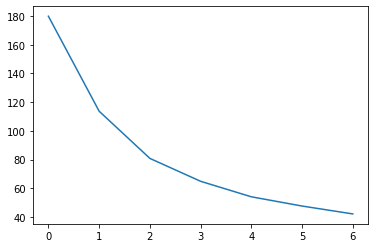

In [14]:
#wss
wss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_ds_scaled)
    wss.append(kmeans.inertia_)
    
plt.plot(wss)

### Silhouette Analysis
#### silhouette score=𝑝−𝑞/𝑚𝑎𝑥(𝑝,𝑞)
#### 𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of
#### 𝑞  is the mean intra-cluster distance to all the points in its own cluster.
#### The value of the silhouette score range lies between -1 to 1.
#### A score closer to 1 indicates that the data point is very similar to other data points in the cluster,
#### A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [15]:
#silhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_ds_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_ds_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5889064222823147
For n_clusters=3, the silhouette score is 0.5489370253660052
For n_clusters=4, the silhouette score is 0.5041317149907137
For n_clusters=5, the silhouette score is 0.44824081702862667
For n_clusters=6, the silhouette score is 0.40398653778101357
For n_clusters=7, the silhouette score is 0.38594616966454287
For n_clusters=8, the silhouette score is 0.3792484049880486


In [16]:
# kmeans = KMeans(n_clusters=3, max_iter=50)
# kmeans.fit(rfm_ds_scaled)
# print(kmeans.labels_)
rfm_ds_final['Cluster_Id'] = lbs
rfm_ds_final.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

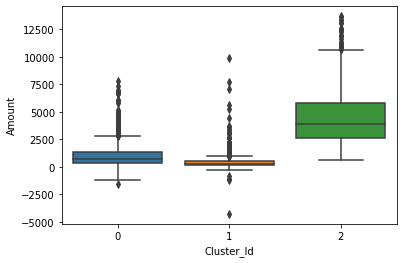

In [17]:
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm_ds_final)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

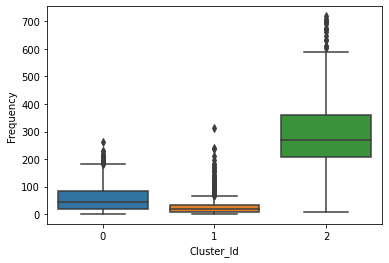

In [18]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm_ds_final)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

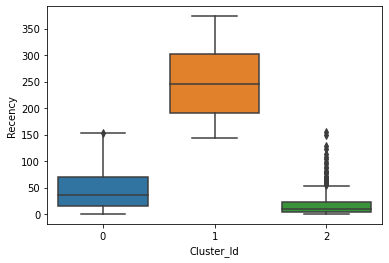

In [19]:
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm_ds_final)